# Tuning experiments for the Movielens dataset

Feel free to re-run this and change hyperparameters as you see fit.

This notebook should also be a good place to load the data only once and then train multiple times, generate charts, etc.


In [47]:
from data_loader import load_data, train_test_split, MovielensDataset
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
import argparse
import yaml
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error

from gmf import GMF
from ncf_mlp import NCF_MLP
from neural_mf import NEURAL_MF

from train import train_gmf, train_joint_nerual_mf, train_mlp, train_neural_mf, train_loop, test_loop

from matplotlib import pyplot as plt

In [48]:
# Starting hyperparameters
learning_rate = 0.05
weight_decay = 0.0000001
epochs = 2
batch_size = 1024
latent_dims = 16
alpha = 0.5
loss = nn.MSELoss()

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# Load the data
dataset = '100k'
data, num_users, num_items = load_data(dataset, rescale_data=True)
print(data.head())
train, test = train_test_split(data)

   user_id  movie_id  rating  timestamp
0        0         0     0.6  881250949
1        1         1     0.6  891717742
2        2         2     0.2  878887116
3        3         3     0.4  880606923
4        4         4     0.2  886397596


In [51]:
train = MovielensDataset(users=train['user_id'], movies=train['movie_id'], ratings = train['rating'])
test = MovielensDataset(users=test['user_id'], movies=test['movie_id'], ratings = test['rating'])

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers= 4)

In [52]:
def plot_learning_curve(param_history, curves, title='Training Curve', save=False):
    """Plot learning curves for a given model's tuning history

    curves -- a dictionary from a curve label to its historical data. The length of the curve history should be equal
              to the length of param_history
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    curve_labels = curves.keys()
    for curve_label in curve_labels:
        curve_data = curves[curve_label]
        ax.plot(param_history, curve_data, label=curve_label)

    fig.suptitle(title)
    fig.legend()
    if save:
        t = title.lower().replace(" ", "-").replace(".","")
        fig.savefig(f"images/{t}.png")
    fig.show()
    

## Tune Hyperparameters for Models

In [5]:
def tune_lr(model_type='gmf', verbose=False, gmf_model=None, mlp_model=None):
    """Tune Learning Rate for a model type"""
    learning_rates = np.array([0.001, 0.01, 0.05, 0.07, 0.1, 0.2])
    rmse_history = []
    test_rmse_history = []
    best_model = None
    best_lr = 0.01
    best_RMSE = np.inf
    for lr in learning_rates:
        if model_type == 'gmf':
            if verbose:
                print('TRAINING GMF')
            train_model = train_gmf
            model = train_model(train_dataloader, test_dataloader, num_users, num_items, epochs, latent_dims,
                                lr, # Param being tuned
                                'adam', criterion=loss, device=device, weight_decay=weight_decay, rescale_data=True)
        elif model_type == 'mlp':
            if verbose:
                print('TRAINING MLP')
            train_model = train_mlp
            model = train_model(train_dataloader, test_dataloader, num_users, num_items, epochs, latent_dims,
                                lr, # Param being tuned
                                'adam', criterion=loss, device=device, weight_decay=weight_decay, rescale_data=True)
        else:
            if verbose:
                print('TRAINING NMF')
            train_model = train_neural_mf
            model = train_model(train_dataloader, test_dataloader, gmf_model, mlp_model, num_users, num_items, epochs, latent_dims,
                                lr, # Param being tuned
                                'adam', criterion=loss, device=device, alpha=alpha, weight_decay=weight_decay, rescale_data=True)

        rmse = test_loop(train_dataloader, model, loss, device, rescale_data=True)
        rmse_history.append(rmse)
        test_rmse = test_loop(test_dataloader, model, loss, device, rescale_data=True)
        test_rmse_history.append(test_rmse)

        # Select the best model based on TRAIN RMSE, not TEST RMSE
        if rmse < best_RMSE:
            best_lr = lr
            best_RMSE = rmse
            best_model = model

    rmse_history = np.array(rmse_history)
    test_rmse_history = np.array(test_rmse_history)
    test_rmse = test_loop(test_dataloader, best_model, loss, device, rescale_data=True)

    if verbose:
        print()
        print('Finished tuning model', model_type)
        print('Best Learning Rate:', best_lr)
        print('Best Train RMSE:', best_RMSE)
        print('Best Test RMSE:', test_rmse)

    curve_data = {
        'Train RMSE': rmse_history,
        'Test RMSE': test_rmse_history,
    }

    return (best_lr, best_model, learning_rates, curve_data)


In [11]:
def tune_dims(model_type='gmf', verbose=False, gmf_model=None, mlp_model=None):
    """Tune Embedding Dimensions for a model type"""
    dims = [4, 8, 16, 32]
    rmse_history = []
    test_rmse_history = []
    best_model = None
    best_dim = 0.01
    best_RMSE = np.inf
    for dim in dims:
        if model_type == 'gmf':
            if verbose:
                print('TRAINING GMF')
            train_model = train_gmf
            model = train_model(train_dataloader, test_dataloader, num_users, num_items, epochs,
                                dim, # Param being tuned 
                                learning_rate, 'adam', criterion=loss, device=device, weight_decay=weight_decay, rescale_data=True)
        elif model_type == 'mlp':
            if verbose:
                print('TRAINING MLP')
            train_model = train_mlp
            model = train_model(train_dataloader, test_dataloader, num_users, num_items, epochs,
                                dim, # Param being tuned 
                                learning_rate, 'adam', criterion=loss, device=device, weight_decay=weight_decay, rescale_data=True)
        else:
            if verbose:
                print('TRAINING NMF')
            train_model = train_neural_mf
            model = train_model(train_dataloader, test_dataloader, gmf_model, mlp_model, num_users, num_items, epochs,
                                dim, # Param being tuned 
                                learning_rate, 'adam', criterion=loss, device=device, alpha=alpha, weight_decay=weight_decay, rescale_data=True)

        rmse = test_loop(train_dataloader, model, loss, device, rescale_data=True)
        rmse_history.append(rmse)
        test_rmse = test_loop(test_dataloader, model, loss, device, rescale_data=True)
        test_rmse_history.append(test_rmse)

        # Select the best model based on TRAIN RMSE, not TEST RMSE
        if rmse < best_RMSE:
            best_dim = dim
            best_RMSE = rmse
            best_model = model

    rmse_history = np.array(rmse_history)
    test_rmse_history = np.array(test_rmse_history)
    test_rmse = test_loop(test_dataloader, best_model, loss, device, rescale_data=True)

    if verbose:
        print()
        print('Finished tuning model', model_type)
        print('Best Embedding Dim:', best_dim)
        print('Best Train RMSE:', best_RMSE)
        print('Best Test RMSE:', test_rmse)

    curve_data = {
        'Train RMSE': rmse_history,
        'Test RMSE': test_rmse_history,
    }

    return (best_dim, best_model, dims, curve_data)


Epoch 1
------------------------


loss: 0.616572  [ 1024/15945812]
loss: 0.042813  [1025024/15945812]
loss: 0.042631  [2049024/15945812]
loss: 0.042374  [3073024/15945812]
loss: 0.041493  [4097024/15945812]
loss: 0.042831  [5121024/15945812]
loss: 0.043302  [6145024/15945812]
loss: 0.040166  [7169024/15945812]
loss: 0.042919  [8193024/15945812]
loss: 0.045461  [9217024/15945812]
loss: 0.042116  [10241024/15945812]
loss: 0.036905  [11265024/15945812]
loss: 0.032219  [12289024/15945812]
loss: 0.031665  [13313024/15945812]
loss: 0.030532  [14337024/15945812]
loss: 0.029799  [15361024/15945812]
Test MSE 0.810639369336749
Test RMSE 0.9003551351198864
Epoch 2
------------------------
loss: 0.031191  [ 1024/15945812]
loss: 0.030186  [1025024/15945812]
loss: 0.035146  [2049024/15945812]
loss: 0.029244  [3073024/15945812]
loss: 0.025950  [4097024/15945812]
loss: 0.024058  [5121024/15945812]
loss: 0.028180  [6145024/15945812]
loss: 0.025063  [7169024/15945812]
loss: 0.029553  [8193024/15945812]
loss: 0.025564  [9217024/15945812]

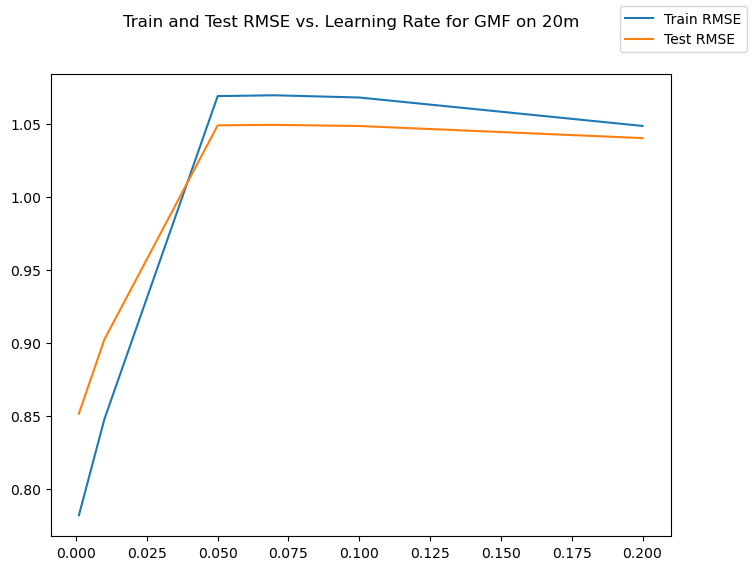

In [68]:
gmf_lr, gmf_model, gmf_lr_history, gmf_lr_curves = tune_lr('gmf')
title = f"Train and Test RMSE vs. Learning Rate for GMF on {dataset}"
plot_learning_curve(gmf_lr_history, gmf_lr_curves, title, True)
print(f"Best LR for GMF on {dataset}", gmf_lr)

Epoch 1
------------------------
loss: 1.014542  [ 1024/15945812]
loss: 0.043406  [1025024/15945812]
loss: 0.044753  [2049024/15945812]
loss: 0.041095  [3073024/15945812]
loss: 0.037922  [4097024/15945812]
loss: 0.035939  [5121024/15945812]
loss: 0.035836  [6145024/15945812]
loss: 0.039137  [7169024/15945812]
loss: 0.035927  [8193024/15945812]
loss: 0.033935  [9217024/15945812]
loss: 0.035272  [10241024/15945812]
loss: 0.034355  [11265024/15945812]
loss: 0.034866  [12289024/15945812]
loss: 0.038258  [13313024/15945812]
loss: 0.038570  [14337024/15945812]
loss: 0.034981  [15361024/15945812]
Test MSE 0.9545923253419828
Test RMSE 0.9770324075188002
Epoch 2
------------------------
loss: 0.037074  [ 1024/15945812]
loss: 0.037191  [1025024/15945812]
loss: 0.039258  [2049024/15945812]
loss: 0.034808  [3073024/15945812]
loss: 0.036466  [4097024/15945812]
loss: 0.036784  [5121024/15945812]
loss: 0.035780  [6145024/15945812]
loss: 0.038118  [7169024/15945812]
loss: 0.035050  [8193024/15945812]


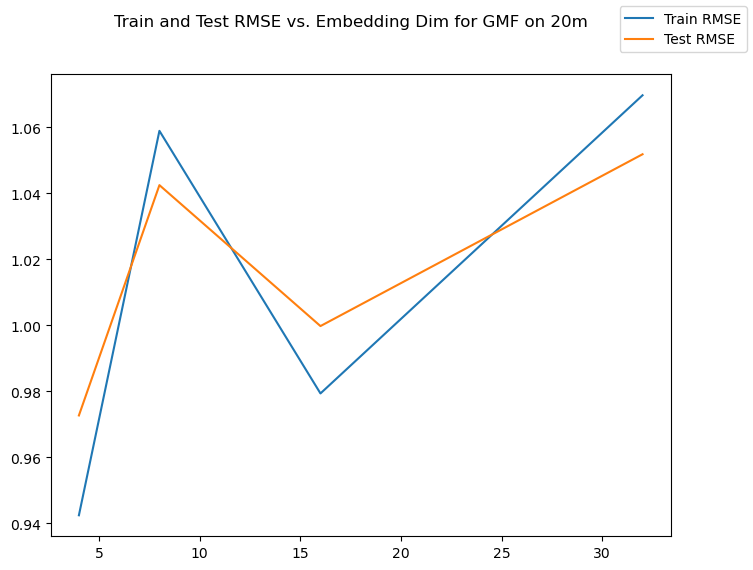

In [13]:
gmf_dim, gmf_model, gmf_dim_history, gmf_dim_curves = tune_dims('gmf')
title = f"Train and Test RMSE vs. Embedding Dim for GMF on {dataset}"
plot_learning_curve(gmf_dim_history, gmf_dim_curves, title, True)
print(f"Best Embedding Dimension for GMF on {dataset}", gmf_dim)

Epoch 1
-------------------------------


loss: 0.225525  [ 1024/15945812]
loss: 0.038606  [1025024/15945812]
loss: 0.033102  [2049024/15945812]
loss: 0.035791  [3073024/15945812]
loss: 0.034167  [4097024/15945812]
loss: 0.030997  [5121024/15945812]
loss: 0.032170  [6145024/15945812]
loss: 0.026501  [7169024/15945812]
loss: 0.030211  [8193024/15945812]
loss: 0.027894  [9217024/15945812]
loss: 0.029796  [10241024/15945812]
loss: 0.031103  [11265024/15945812]
loss: 0.029677  [12289024/15945812]
loss: 0.029730  [13313024/15945812]
loss: 0.031286  [14337024/15945812]
loss: 0.029343  [15361024/15945812]
Test MSE 0.7981708636553706
Test RMSE 0.8934040875524192
Epoch 2
-------------------------------
loss: 0.030569  [ 1024/15945812]
loss: 0.028693  [1025024/15945812]
loss: 0.028079  [2049024/15945812]
loss: 0.029555  [3073024/15945812]
loss: 0.030745  [4097024/15945812]
loss: 0.031634  [5121024/15945812]
loss: 0.029537  [6145024/15945812]
loss: 0.030461  [7169024/15945812]
loss: 0.029776  [8193024/15945812]
loss: 0.027817  [9217024/1

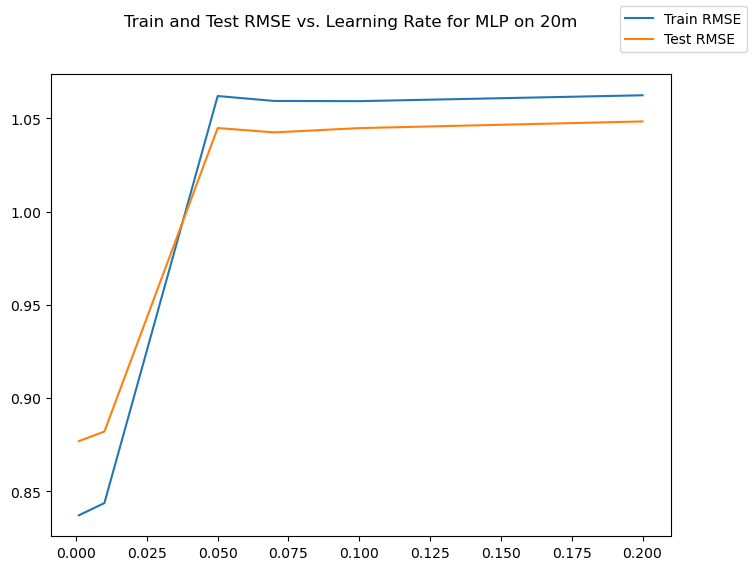

In [14]:
mlp_lr, mlp_model, mlp_lr_history, mlp_lr_curves = tune_lr('mlp')
title = f"Train and Test RMSE vs. Learning Rate for MLP on {dataset}"
plot_learning_curve(mlp_lr_history, mlp_lr_curves, title, True)
print(f"Best Learning Rate for MLP on {dataset}", mlp_lr)

Epoch 1
-------------------------------
loss: 1.116874  [ 1024/15945812]
loss: 0.030330  [1025024/15945812]
loss: 0.033413  [2049024/15945812]
loss: 0.033834  [3073024/15945812]
loss: 0.031662  [4097024/15945812]
loss: 0.027759  [5121024/15945812]
loss: 0.033184  [6145024/15945812]
loss: 0.032450  [7169024/15945812]
loss: 0.032362  [8193024/15945812]
loss: 0.033127  [9217024/15945812]
loss: 0.031617  [10241024/15945812]
loss: 0.028507  [11265024/15945812]
loss: 0.031532  [12289024/15945812]
loss: 0.035373  [13313024/15945812]
loss: 0.033189  [14337024/15945812]
loss: 0.035661  [15361024/15945812]
Test MSE 0.874727843387357
Test RMSE 0.9352688615512423
Epoch 2
-------------------------------
loss: 0.033736  [ 1024/15945812]
loss: 0.030650  [1025024/15945812]
loss: 0.031578  [2049024/15945812]
loss: 0.030214  [3073024/15945812]
loss: 0.033802  [4097024/15945812]
loss: 0.034733  [5121024/15945812]
loss: 0.032736  [6145024/15945812]
loss: 0.034739  [7169024/15945812]
loss: 0.032931  [81930

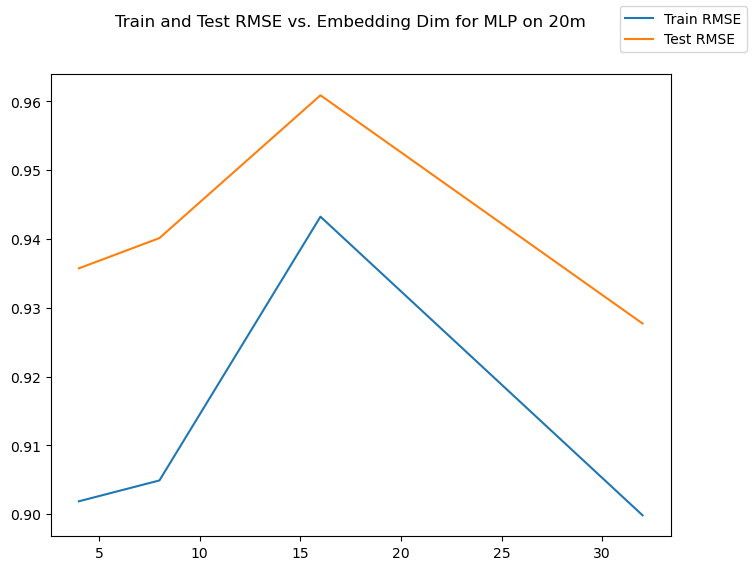

In [15]:
mlp_dim, mlp_model, mlp_dim_history, mlp_dim_curves = tune_dims('mlp')
title = f"Train and Test RMSE vs. Embedding Dim for MLP on {dataset}"
plot_learning_curve(mlp_dim_history, mlp_dim_curves, title, True)
print(f"Best Embedding Dimension for MLP on {dataset}", mlp_dim)

Epoch 1
------------------------
loss: 0.125934  [ 1024/15945812]
loss: 0.034734  [1025024/15945812]
loss: 0.034944  [2049024/15945812]
loss: 0.031469  [3073024/15945812]
loss: 0.028040  [4097024/15945812]
loss: 0.029949  [5121024/15945812]
loss: 0.029912  [6145024/15945812]
loss: 0.029631  [7169024/15945812]
loss: 0.027694  [8193024/15945812]
loss: 0.028323  [9217024/15945812]
loss: 0.030648  [10241024/15945812]
loss: 0.029718  [11265024/15945812]
loss: 0.028390  [12289024/15945812]
loss: 0.029991  [13313024/15945812]
loss: 0.029014  [14337024/15945812]
loss: 0.029624  [15361024/15945812]
Test MSE 0.7700475713923641
Test RMSE 0.8775235446370451
Epoch 2
------------------------
loss: 0.024776  [ 1024/15945812]
loss: 0.026746  [1025024/15945812]
loss: 0.028918  [2049024/15945812]
loss: 0.027846  [3073024/15945812]
loss: 0.026914  [4097024/15945812]
loss: 0.027386  [5121024/15945812]
loss: 0.030408  [6145024/15945812]
loss: 0.027526  [7169024/15945812]
loss: 0.028831  [8193024/15945812]


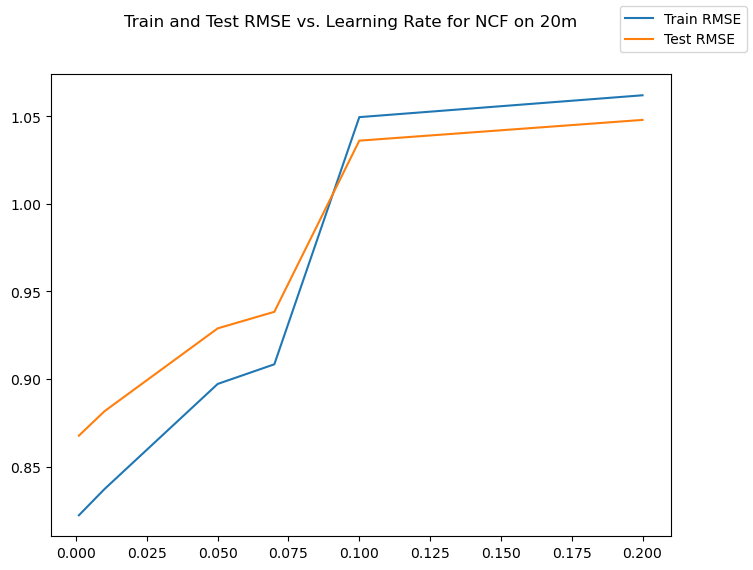

In [16]:
ncf_lr, ncf_model, ncf_lr_history, ncf_lr_curves = tune_lr('ncf', gmf_model=gmf_model, mlp_model=mlp_model)
title = f"Train and Test RMSE vs. Learning Rate for NCF on {dataset}"
plot_learning_curve(ncf_lr_history, ncf_lr_curves, title, True)
print(f"Best Learning Rate for NCF on {dataset}", ncf_lr)

Epoch 1
------------------------


loss: 0.097825  [ 1024/15945812]
loss: 0.031000  [1025024/15945812]
loss: 0.032747  [2049024/15945812]
loss: 0.030965  [3073024/15945812]
loss: 0.028762  [4097024/15945812]
loss: 0.034955  [5121024/15945812]
loss: 0.032868  [6145024/15945812]
loss: 0.030627  [7169024/15945812]
loss: 0.033926  [8193024/15945812]
loss: 0.030145  [9217024/15945812]
loss: 0.034415  [10241024/15945812]
loss: 0.033199  [11265024/15945812]
loss: 0.031839  [12289024/15945812]
loss: 0.033863  [13313024/15945812]
loss: 0.033663  [14337024/15945812]
loss: 0.032440  [15361024/15945812]
Test MSE 0.8647577468867794
Test RMSE 0.9299235166866033
Epoch 2
------------------------
loss: 0.033203  [ 1024/15945812]
loss: 0.033691  [1025024/15945812]
loss: 0.030753  [2049024/15945812]
loss: 0.033331  [3073024/15945812]
loss: 0.032072  [4097024/15945812]
loss: 0.033230  [5121024/15945812]
loss: 0.032400  [6145024/15945812]
loss: 0.028904  [7169024/15945812]
loss: 0.033661  [8193024/15945812]
loss: 0.033345  [9217024/15945812

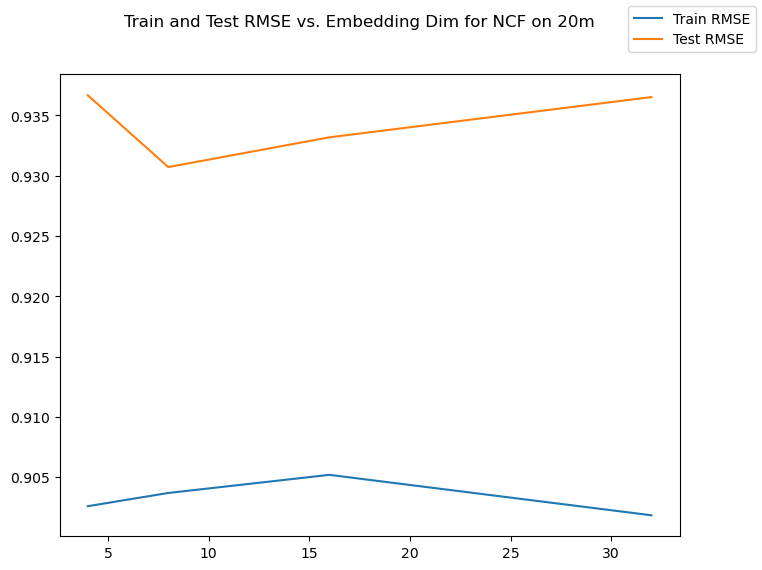

In [17]:
# Note: by specifying None for the pretrained models, they will be initialized from scratch, using
# the specified embedding dimensionality.
ncf_dim, ncf_model, ncf_dim_history, ncf_dim_curves = tune_dims('ncf', gmf_model=None, mlp_model=None)
title = f"Train and Test RMSE vs. Embedding Dim for NCF on {dataset}"
plot_learning_curve(ncf_dim_history, ncf_dim_curves, title, True)
print(f"Best Embedding Dimensionality for NCF on {dataset}", ncf_dim)

In [19]:
print(f"Best Embedding Dimensionality for NCF on {dataset}", ncf_dim)

Best Embedding Dimensionality for NCF on 20m 32


# Final Training of Models

TRAINING GMF
Epoch 1
------------------------


loss: 0.917677  [ 1024/15945812]
loss: 0.046885  [1025024/15945812]
loss: 0.046660  [2049024/15945812]
loss: 0.044594  [3073024/15945812]
loss: 0.044760  [4097024/15945812]
loss: 0.044113  [5121024/15945812]
loss: 0.047092  [6145024/15945812]
loss: 0.045372  [7169024/15945812]
loss: 0.044252  [8193024/15945812]
loss: 0.043717  [9217024/15945812]
loss: 0.043179  [10241024/15945812]
loss: 0.044244  [11265024/15945812]
loss: 0.045206  [12289024/15945812]
loss: 0.045637  [13313024/15945812]
loss: 0.043815  [14337024/15945812]
loss: 0.038122  [15361024/15945812]
Avg loss: 0.039577 

Test MSE 0.9894309105309593
Test RMSE 0.9947014177787017
Epoch 2
------------------------
loss: 0.038665  [ 1024/15945812]
loss: 0.037367  [1025024/15945812]
loss: 0.033921  [2049024/15945812]
loss: 0.032917  [3073024/15945812]
loss: 0.028497  [4097024/15945812]
loss: 0.030026  [5121024/15945812]
loss: 0.027015  [6145024/15945812]
loss: 0.030507  [7169024/15945812]
loss: 0.028102  [8193024/15945812]
loss: 0.0288

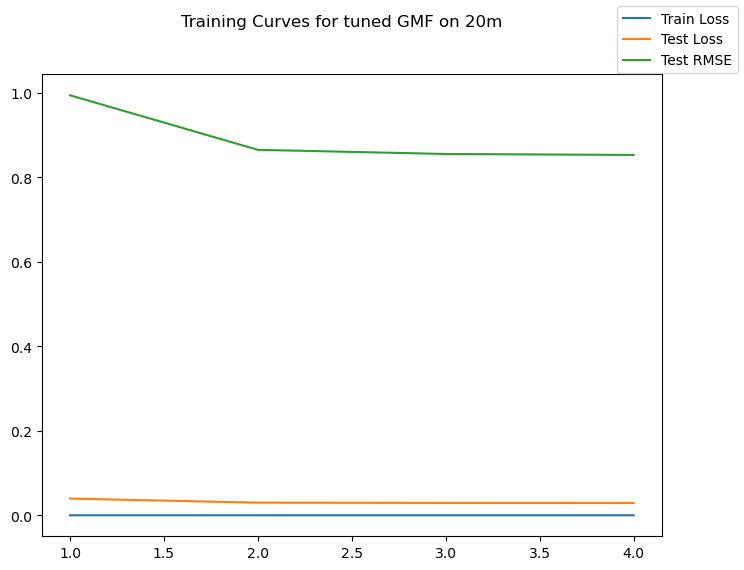

In [25]:
# GMF Hyperparameters
learning_rate = 0.001
weight_decay = 0.0000001
epochs = 4
batch_size = 1024
latent_dims = 4
alpha = 0.5
loss = nn.MSELoss()

print('TRAINING GMF')
train_model = train_gmf
final_gmf_model, train_loss, test_loss, test_rmse = train_model(train_dataloader,
                                                      test_dataloader,
                                                      num_users,
                                                      num_items,
                                                      epochs,
                                                      latent_dims,
                                                      learning_rate,
                                                      'adam',
                                                      criterion=loss,
                                                      device=device,
                                                      weight_decay=weight_decay,
                                                      rescale_data=True)


model_name = f"models/final_gmf_model_{dataset}"
torch.save(final_gmf_model.state_dict(), model_name)

curve_data = {
    'Train Loss': train_loss,
    'Test Loss': test_loss,
    'Test RMSE': test_rmse,
}
title = f"Training Curves for tuned GMF on {dataset}"
plot_learning_curve(np.arange(1, epochs+1), curve_data, title, True)

TRAINING MLP
Epoch 1
-------------------------------


loss: 0.568002  [ 1024/15945812]
loss: 0.039790  [1025024/15945812]
loss: 0.035519  [2049024/15945812]
loss: 0.034196  [3073024/15945812]
loss: 0.035445  [4097024/15945812]
loss: 0.031850  [5121024/15945812]
loss: 0.029452  [6145024/15945812]
loss: 0.030576  [7169024/15945812]
loss: 0.030913  [8193024/15945812]
loss: 0.031117  [9217024/15945812]
loss: 0.028190  [10241024/15945812]
loss: 0.029128  [11265024/15945812]
loss: 0.029806  [12289024/15945812]
loss: 0.030743  [13313024/15945812]
loss: 0.025083  [14337024/15945812]
loss: 0.029603  [15361024/15945812]
Avg loss: 0.032123 

Test MSE 0.8030537716800017
Test RMSE 0.8961326752663367
Epoch 2
-------------------------------
loss: 0.030763  [ 1024/15945812]
loss: 0.027192  [1025024/15945812]
loss: 0.027239  [2049024/15945812]
loss: 0.030660  [3073024/15945812]
loss: 0.030782  [4097024/15945812]
loss: 0.026741  [5121024/15945812]
loss: 0.026860  [6145024/15945812]
loss: 0.029238  [7169024/15945812]
loss: 0.027288  [8193024/15945812]
loss:

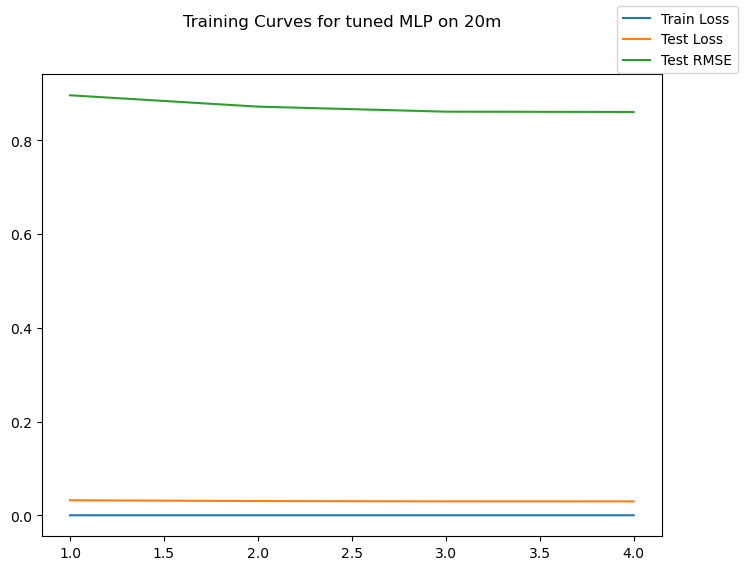

In [26]:
# MLP Hyperparameters
learning_rate = 0.001
weight_decay = 0.0000001
epochs = 4
batch_size = 1024
latent_dims = 32
alpha = 0.5
loss = nn.MSELoss()

print('TRAINING MLP')
train_model = train_mlp
final_mlp_model, train_loss, test_loss, test_rmse = train_model(train_dataloader,
                                                      test_dataloader,
                                                      num_users,
                                                      num_items,
                                                      epochs,
                                                      latent_dims,
                                                      learning_rate,
                                                      'adam',
                                                      criterion=loss,
                                                      device=device,
                                                      weight_decay=weight_decay,
                                                      rescale_data=True)


model_name = f"models/final_mlp_model_{dataset}"
torch.save(final_mlp_model.state_dict(), model_name)

curve_data = {
    'Train Loss': train_loss,
    'Test Loss': test_loss,
    'Test RMSE': test_rmse,
}
title = f"Training Curves for tuned MLP on {dataset}"
plot_learning_curve(np.arange(1, epochs+1), curve_data, title, True)

PRETRAINING GMF
Epoch 1
------------------------


loss: 0.971519  [ 1024/15945812]
loss: 0.055000  [1025024/15945812]
loss: 0.048120  [2049024/15945812]
loss: 0.042417  [3073024/15945812]
loss: 0.044311  [4097024/15945812]
loss: 0.043971  [5121024/15945812]
loss: 0.048192  [6145024/15945812]
loss: 0.043231  [7169024/15945812]
loss: 0.039006  [8193024/15945812]
loss: 0.033176  [9217024/15945812]
loss: 0.029561  [10241024/15945812]
loss: 0.031623  [11265024/15945812]
loss: 0.027647  [12289024/15945812]
loss: 0.031495  [13313024/15945812]
loss: 0.027189  [14337024/15945812]
loss: 0.027853  [15361024/15945812]
Avg loss: 0.031862 

Test MSE 0.7965283445540001
Test RMSE 0.8924843665599976
Epoch 2
------------------------
loss: 0.028991  [ 1024/15945812]
loss: 0.026254  [1025024/15945812]
loss: 0.028060  [2049024/15945812]
loss: 0.025611  [3073024/15945812]
loss: 0.030032  [4097024/15945812]
loss: 0.028550  [5121024/15945812]
loss: 0.027172  [6145024/15945812]
loss: 0.028619  [7169024/15945812]
loss: 0.027485  [8193024/15945812]
loss: 0.0258

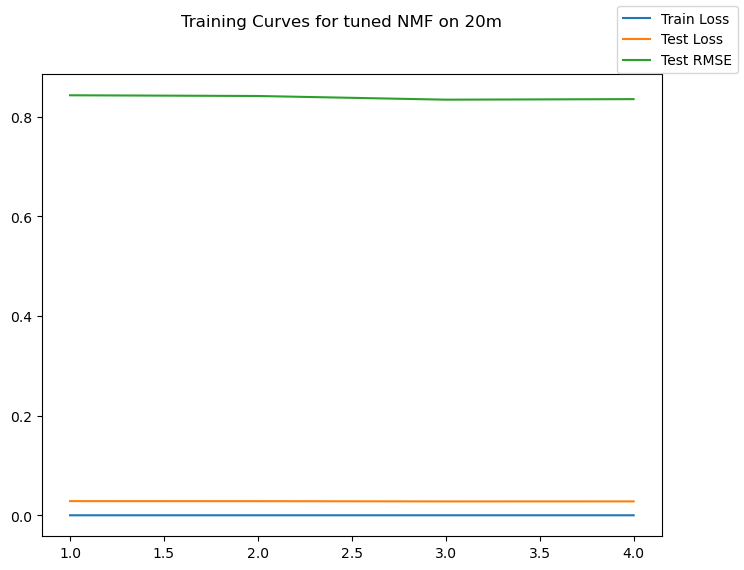

In [27]:
# NMF Hyperparameters
learning_rate = 0.001
weight_decay = 0.0000001
epochs = 4
batch_size = 1024
latent_dims = 32
alpha = 0.5
loss = nn.MSELoss()

print('PRETRAINING GMF')
pretrain_gmf, _, __, ___ = train_gmf(train_dataloader,
                   test_dataloader,
                   num_users,
                   num_items,
                   2, # Just pretrain a few epochs instead of the full amount
                   latent_dims,
                   learning_rate,
                   'adam',
                   criterion=loss,
                   device=device,
                   weight_decay=weight_decay,
                   rescale_data=True)
# Can reuse final MLP since the expected latent dims happen to match

print('TRAINING NMF')
train_model = train_neural_mf
final_nmf_model, train_loss, test_loss, test_rmse = train_model(train_dataloader,
                                                      test_dataloader,
                                                      pretrain_gmf,
                                                      final_mlp_model,
                                                      num_users,
                                                      num_items,
                                                      epochs,
                                                      latent_dims,
                                                      learning_rate,
                                                      'adam',
                                                      criterion=loss,
                                                      device=device,
                                                      alpha=alpha,
                                                      weight_decay=weight_decay,
                                                      rescale_data=True)


model_name = f"models/final_nmf_model_{dataset}"
torch.save(final_nmf_model.state_dict(), model_name)

curve_data = {
    'Train Loss': train_loss,
    'Test Loss': test_loss,
    'Test RMSE': test_rmse,
}
title = f"Training Curves for tuned NMF on {dataset}"
plot_learning_curve(np.arange(1, epochs+1), curve_data, title, True)


# Evaluation of Models

In [53]:
from eval import hit_rate, precision_at_k
from train import train_gmf, train_mlp, train_neural_mf
from ipywidgets import FloatProgress

In [54]:
final_gmf_model = GMF(num_users, num_items, 4)
final_gmf_model.load_state_dict(torch.load(f"models/final_gmf_model_{dataset}"), strict=False)
final_gmf_model = final_gmf_model.to(device)

# user_ratio = 0.001 # set to 1 to compute this exactly
user_ratio = 1 # set to 1 to compute this exactly
eval_users = int(user_ratio * num_users)

hr, users_to_ratings = hit_rate(final_gmf_model, 40, eval_users, num_items, data, device, 10_000)
pk, users_to_ratings = precision_at_k(final_gmf_model, 40, eval_users, num_items, data, device, 10_000)

print("Tuned GMF Hit Rate (k=20)\t", hr)
print("Tuned GMF Precision at k=20\t", pk)

  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

Tuned GMF Hit Rate (k=20)	 0.7285259809119831
Tuned GMF Precision at k=20	 0.05503711558854719


In [55]:
final_mlp_model = NCF_MLP(num_users, num_items, 16)
final_mlp_model.load_state_dict(torch.load(f"models/final_mlp_model_{dataset}"), strict=False)
final_mlp_model = final_mlp_model.to(device)

# user_ratio = 0.001 # set to 1 to compute this exactly
user_ratio = 1 # set to 1 to compute this exactly
eval_users = int(user_ratio * num_users)

hr, users_to_ratings = hit_rate(final_mlp_model, 40, eval_users, num_items, data, device, 10_000)
pk, users_to_ratings = precision_at_k(final_mlp_model, 40, eval_users, num_items, data, device, 10_000)

print("Tuned MLP Hit Rate (k=20)\t", hr)
print("Tuned MLP Precision at k=20\t", pk)

  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

Tuned MLP Hit Rate (k=20)	 0.5259809119830329
Tuned MLP Precision at k=20	 0.034915164369034996


In [56]:
final_nmf_model = NEURAL_MF(num_users, num_items, 16)
final_nmf_model.load_state_dict(torch.load(f"models/final_nmf_model_{dataset}"), strict=False)
final_nmf_model = final_nmf_model.to(device)

# user_ratio = 0.001 # set to 1 to compute this exactly
user_ratio = 1 # set to 1 to compute this exactly
eval_users = int(user_ratio * num_users)

hr, users_to_ratings = hit_rate(final_nmf_model, 40, eval_users, num_items, data, device, 10_000)
pk, users_to_ratings = precision_at_k(final_nmf_model, 40, eval_users, num_items, data, device, 10_000)

print("Tuned GMF Hit Rate (k=20)\t\t", hr)
print("Tuned GMF Precision at k=20\t", pk)

  0%|          | 0/943 [00:00<?, ?it/s]

  0%|          | 0/943 [00:00<?, ?it/s]

Tuned GMF Hit Rate (k=20)		 0.6585365853658537
Tuned GMF Precision at k=20	 0.05312831389183457
